# Network Analysis for Information Retrieval - Part 2

Elyes KHALFALLAH & Mohammed ali EL ADLOUNI

16/03/2025

---

---


## Exercice 4 : Structurer le corpus


### 0. Etapes préliminaires


In [1]:
# Useful libraries
import numpy as np
import pandas as pd
from fonctions import *
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer


### 1. Espace des mots avec algorithme de clustering k-means


In [2]:
# # load X_tf.npy and X_tf_idf.npy
# X_tf = np.load('X_tf.npy', allow_pickle=True)
# X_tfidf = np.load('X_tfidf.npy', allow_pickle=True)

# # convert X_tf and X_tfidf to dense matrices
# X_tf = X_tf.item()
# X_tfidf = X_tfidf.item()

# # print shape oshape of the matrix X_tfidf is ()f X_tfidf
# print(f"shape of the matrix X_tfidf is {X_tfidf.shape}")


In [3]:
# Nous allons maintenant construire la matrice Documents x Termes en adoprant le schéma de pondération TF-IDF

# Load the data
data_text = pd.read_csv("data_text.csv")
print(data_text.shape)


(40596, 10)


In [4]:
# When removing stopwords and most common words, some rows may become empty. We need to remove them.
data_text = data_text.dropna(subset=["text"])
print(data_text.shape)


(36172, 10)


In [5]:
# Define the vectorizer
tf_vectorizer = TfidfVectorizer(use_idf=False)

# Fit and transform the vectorizer on the 'text' column
X_tf = tf_vectorizer.fit_transform(data_text["text"])

# Show the shape of the resulting matrix
X_tf.shape


(36172, 8409)

In [6]:
# Step 1: Apply KMeans Clustering
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X_tf)

# Step 2: Reduce to 2D for visualization
# Normalize before PCA
scaler = StandardScaler(with_mean=False)  # Set False for sparse data
X_tf = scaler.fit_transform(X_tf)

# Use PCA
# pca = PCA(n_components=2)
# X_tfidf_pca = pca.fit_transform(X_tfidf.toarray())


# Use TruncatedSVD instead of PCA
svd = TruncatedSVD(n_components=2, random_state=42)
X_tf_pca = svd.fit_transform(X_tf)

# Check explained variance to see if one component dominates
print("Explained variance ratio:", svd.explained_variance_ratio_)


Explained variance ratio: [0.00086826 0.00071755]


In [7]:
print(np.unique(labels))

# print how percentage of each unique values in variable "labels"
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)


[0 1 2 3 4 5 6 7]
[[    0 34460]
 [    1   292]
 [    2   136]
 [    3    86]
 [    4   713]
 [    5   269]
 [    6    58]
 [    7   158]]


In [8]:
# Use t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tf_tsne = tsne.fit_transform(X_tf[:1000].toarray())


### Apply Latent Dirichlet Allocation (LDA)


C:\Users\elyes\AppData\Local\Temp\ipykernel_16812\2331822676.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 8)  # "tab10" provides 10 distinct colors, limiting to 8


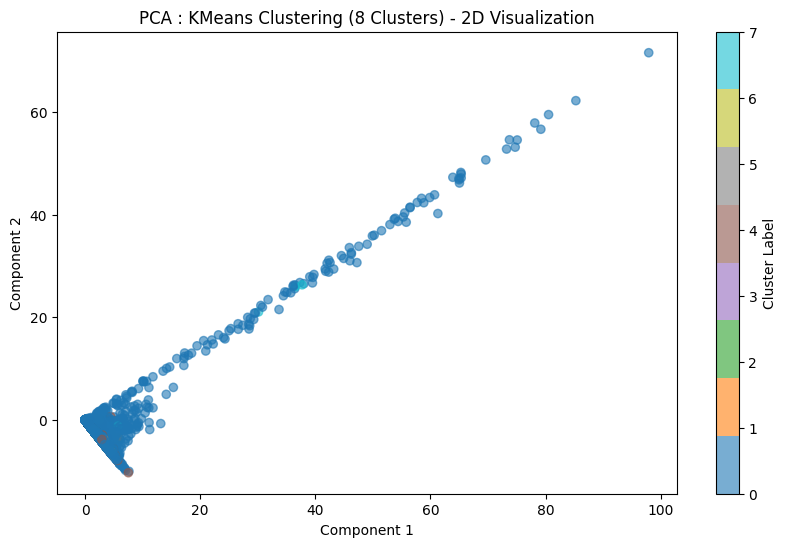

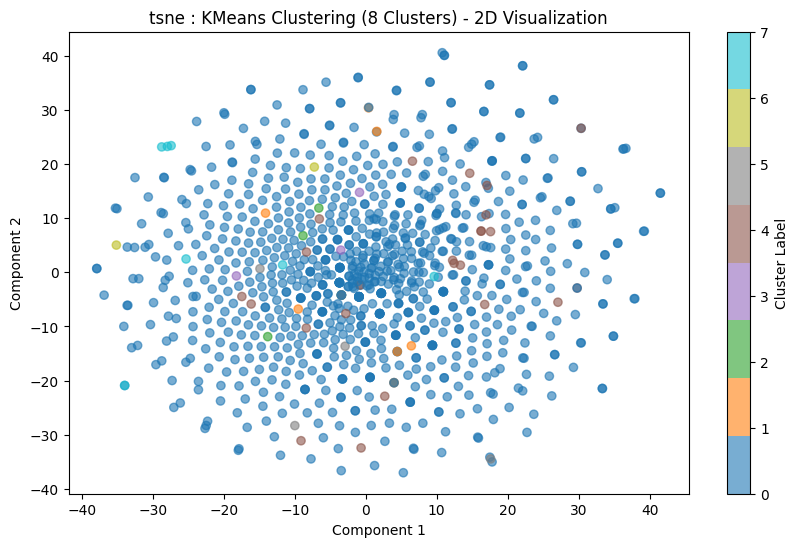

In [9]:
# Step 3: Plot the clusters

cmap = plt.cm.get_cmap("tab10", 8)  # "tab10" provides 10 distinct colors, limiting to 8

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tf_pca[:, 0], X_tf_pca[:, 1], c=labels, cmap=cmap, alpha=0.6)
plt.colorbar(scatter, label="Cluster Label")
plt.title("PCA : KMeans Clustering (8 Clusters) - 2D Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_tf_tsne[:1000, 0], X_tf_tsne[:1000, 1], c=labels[:1000], cmap=cmap, alpha=0.6
)
plt.colorbar(scatter, label="Cluster Label")
plt.title("tsne : KMeans Clustering (8 Clusters) - 2D Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [10]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 8
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
X_topics = lda_model.fit_transform(X_tf)


In [11]:
X_topics.shape


(36172, 8)

In [12]:
X_topics[0]


array([0.21464133, 0.57736141, 0.00065539, 0.00065542, 0.00065572,
       0.00065556, 0.00065558, 0.20471959])

## Exercice 5 : Visualisation du corpus


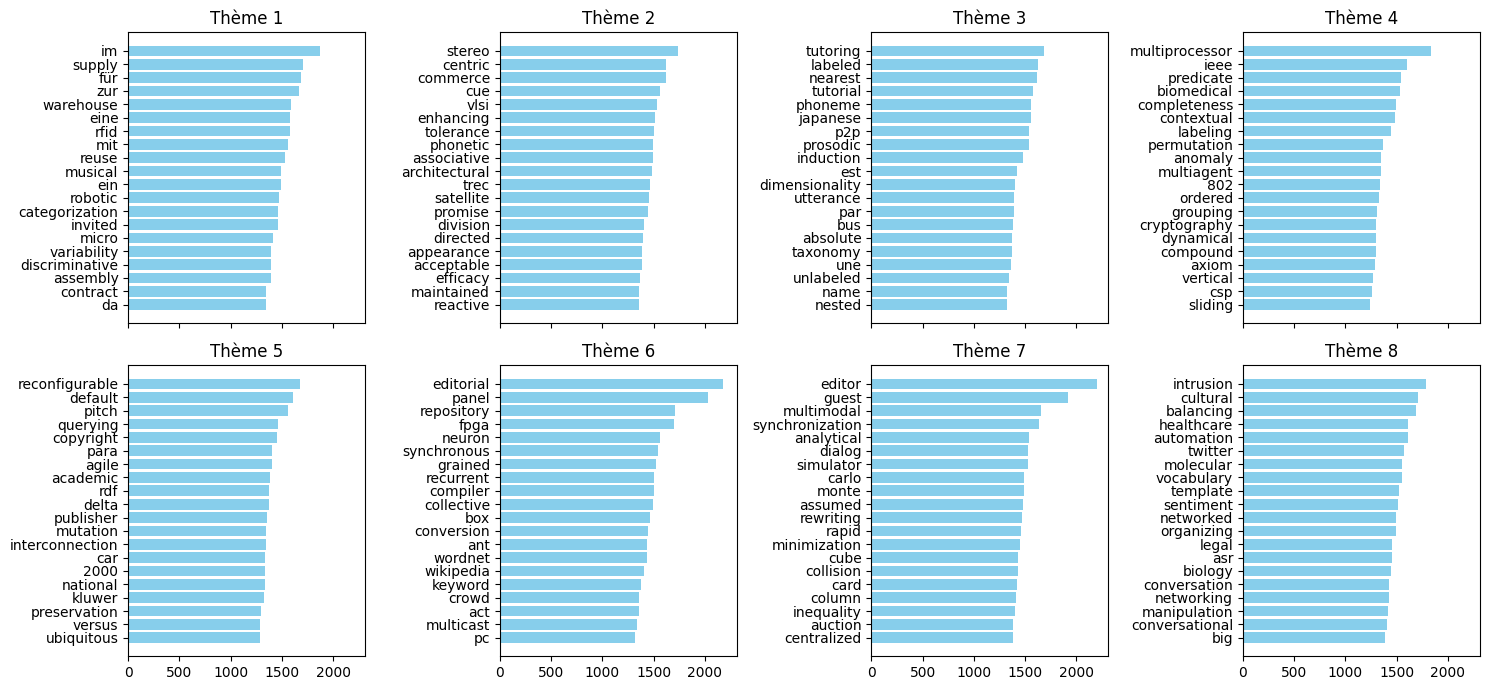

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer


# Récupérer le vocabulaire
feature_names = tf_vectorizer.get_feature_names_out()

# Nombre de mots à afficher par thème
top_n_words = 20

# Afficher les mots les plus importants de chaque thème
fig, axes = plt.subplots(2, 4, figsize=(15, 7), sharex=True)
axes = axes.flatten()

for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[
        -top_n_words:
    ]  # Indices des mots les plus importants
    top_words = [feature_names[i] for i in top_words_idx]  # Convertir indices en mots
    top_values = topic[top_words_idx]  # Poids des mots

    # Tracer le bar plot
    ax = axes[topic_idx]
    ax.barh(top_words, top_values, color="skyblue")
    ax.set_title(f"Thème {topic_idx+1}")

plt.tight_layout()
plt.show()


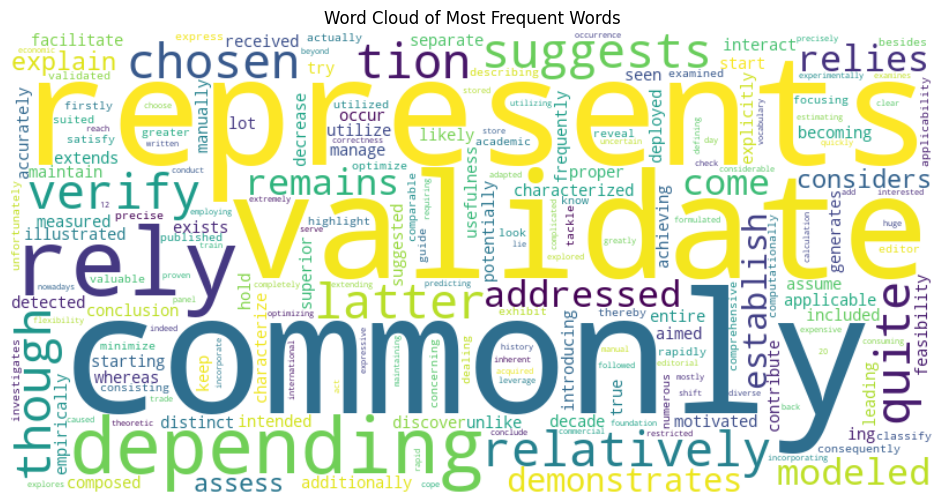

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Convert sparse matrix (X_tf) to an array of word counts
word_counts = X_tf.toarray().sum(axis=0)

# Map word counts to feature names (words)
word_freq = dict(zip(tf_vectorizer.get_feature_names_out(), word_counts))

# Generate and plot the word cloud
wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Word Cloud of Most Frequent Words")
plt.show()


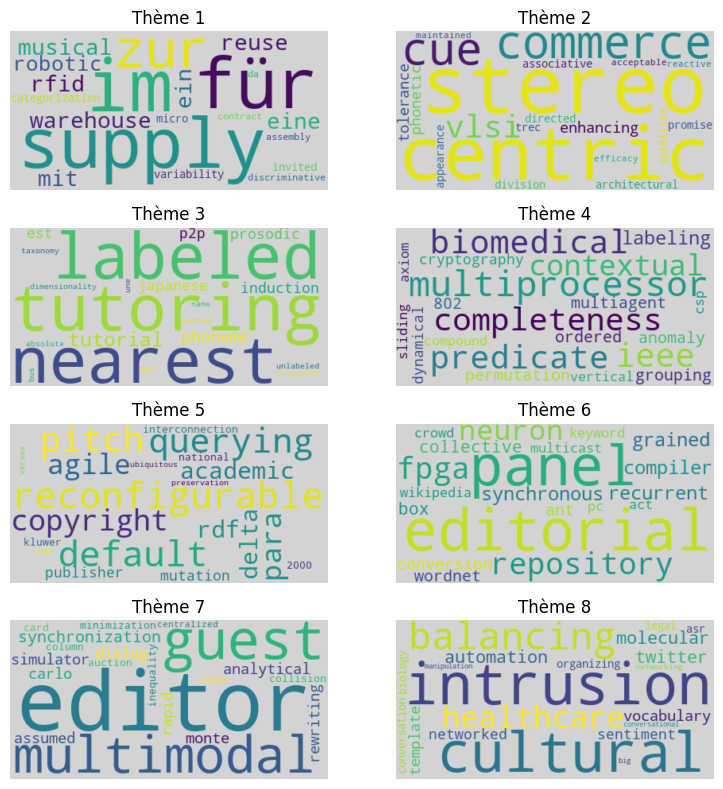

In [15]:
# --- Word Clouds for Each Topic ---
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes = axes.flatten()

for topic_idx, topic in enumerate(lda_model.components_):
    # Get word frequencies for this topic
    top_words_idx = topic.argsort()[-top_n_words:]  # Top word indices
    top_words = [feature_names[i] for i in top_words_idx]  # Convert to actual words
    top_values = topic[top_words_idx]  # Weights

    # Create a dictionary of word frequencies
    word_freq = {word: value for word, value in zip(top_words, top_values)}

    # Generate word cloud
    wordcloud = WordCloud(
        width=400, height=200, background_color="lightgray"
    ).generate_from_frequencies(word_freq)

    # Display word cloud
    ax = axes[topic_idx]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Thème {topic_idx+1}")

plt.tight_layout()
plt.show()


In [16]:
# import networkx as nx
# import seaborn as sns
# import numpy as np
# import pandas as pd

# # Convert X_tf to a term co-occurrence matrix
# co_occurrence_matrix = (X_tf.T @ X_tf)  # Compute word co-occurrence

# # Convert to DataFrame
# words = tf_vectorizer.get_feature_names_out()
# co_df = pd.DataFrame(co_occurrence_matrix.toarray(), index=words, columns=words)

# # Remove diagonal (self-co-occurrence)
# np.fill_diagonal(co_df.values, 0)

# # Select top co-occurring words
# top_n = 20
# co_df = co_df.stack().reset_index()
# co_df.columns = ["Word1", "Word2", "Co-occurrence"]
# co_df = co_df.sort_values(by="Co-occurrence", ascending=False).head(top_n)

# # Create a graph
# G = nx.Graph()

# # Add edges based on co-occurrence
# for _, row in co_df.iterrows():
#     G.add_edge(row["Word1"], row["Word2"], weight=row["Co-occurrence"])

# # Plot network graph
# plt.figure(figsize=(10, 8))
# pos = nx.spring_layout(G, seed=42)
# edges = G.edges(data=True)

# # Draw nodes and edges
# nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=2000)
# nx.draw_networkx_edges(G, pos, alpha=0.6)
# nx.draw_networkx_labels(G, pos, font_size=10)

# # Add edge weights as labels
# edge_labels = {(u, v): d["weight"] for u, v, d in edges}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# plt.title("Word Co-occurrence Network")
# plt.show()


In [17]:
# # Filter for top N co-occurrences
# top_n_edges = 20
# co_df_filtered = co_df_stack.sort_values(by="Co-occurrence", ascending=False).head(top_n_edges)

# # Create graph
# G = nx.Graph()
# for _, row in co_df_filtered.iterrows():
#     G.add_edge(row["Word1"], row["Word2"], weight=row["Co-occurrence"])

# # Adjust edge widths based on co-occurrence strength
# edge_weights = [G[u][v]['weight'] / max(co_df_filtered["Co-occurrence"]) * 10 for u, v in G.edges()]

# # Plot the improved graph
# plt.figure(figsize=(10, 8))
# pos = nx.spring_layout(G, seed=42, k=0.5)  # Better node spacing
# nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=12, width=edge_weights)
# plt.title("Improved Word Co-occurrence Network")
# plt.show()


In [18]:
# # Convert co-occurrence matrix to a list of word pairs
# co_df_stack = co_df.stack().reset_index()
# co_df_stack.columns = ["Word1", "Word2", "Co-occurrence"]

# # Remove self-co-occurrence
# co_df_stack = co_df_stack[co_df_stack["Word1"] != co_df_stack["Word2"]]

# # Select the top N co-occurring pairs
# top_n_pairs = 15
# co_df_stack = co_df_stack.sort_values(by="Co-occurrence", ascending=False).head(top_n_pairs)

# # Plot the bar chart
# plt.figure(figsize=(12, 6))
# sns.barplot(y=co_df_stack["Co-occurrence"], x=[f"{w1} & {w2}" for w1, w2 in zip(co_df_stack["Word1"], co_df_stack["Word2"])], palette="viridis")
# plt.xticks(rotation=45, ha="right")
# plt.ylabel("Co-occurrence Count")
# plt.xlabel("Word Pairs")
# plt.title("Top Word Co-occurrences")
# plt.show()


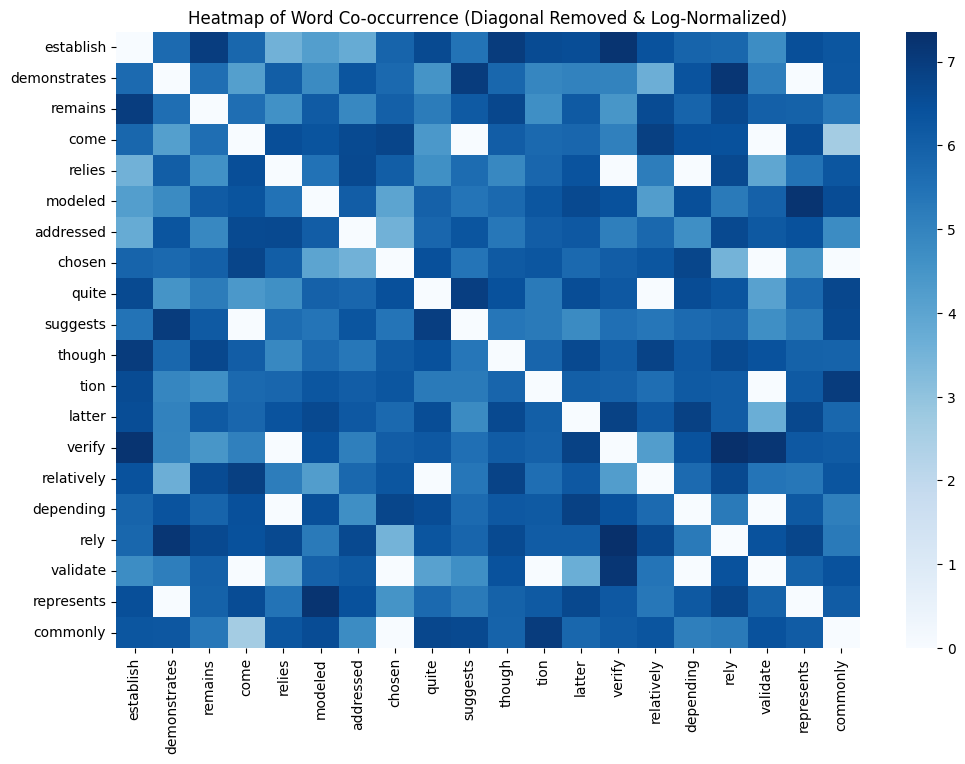

In [19]:
# Convert the co-occurrence matrix to a DataFrame
words = tf_vectorizer.get_feature_names_out()
co_occurrence_matrix = (X_tf.T @ X_tf).toarray()

# Convert to DataFrame
co_df = pd.DataFrame(co_occurrence_matrix, index=words, columns=words)

# Remove self-co-occurrences (set diagonal to 0)
np.fill_diagonal(co_df.values, 0)

# Normalize with log transformation to make small values visible
co_df_log = np.log1p(co_df)  # log1p(x) = log(1 + x) (avoids log(0) issues)

# Select the top N words based on frequency
top_n = 20
word_frequencies = X_tf.toarray().sum(axis=0)
top_words_idx = np.argsort(word_frequencies)[-top_n:]
co_df_top = co_df_log.iloc[top_words_idx, top_words_idx]

# Plot the improved heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(co_df_top, cmap="Blues", annot=False, xticklabels=True, yticklabels=True)
plt.title("Heatmap of Word Co-occurrence (Diagonal Removed & Log-Normalized)")
plt.show()
